In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse
import transformers
import torch
import re
import random
import math
import spacy
import textstat
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from transformers import RobertaTokenizer, RobertaForMaskedLM
from scipy.stats.mstats import winsorize
from typing import List, Dict
from scipy.stats import iqr, trimboth
from scipy.stats.mstats import winsorize

In [90]:
def iqr_normalize(data, scale_min=0, scale_max=5):
    q1, q3 = np.percentile(data, [10, 90])
    iqr_val = iqr(data)
    normalized_data = (data - q1) / iqr_val
    scaled_data = normalized_data * (scale_max - scale_min) + scale_min
    return np.clip(scaled_data, scale_min, scale_max)

def winsorize_normalize(data, scale_min=0, scale_max=5, lower_bound= 0.05, upper_bound= 0.05, max_value=None):
    winsorized_data = winsorize(data, limits=[lower_bound, upper_bound])
    min_value = np.min(winsorized_data)
    if max_value is None:
        max_value = np.max(winsorized_data)
    normalized_data = (winsorized_data - min_value) / (max_value - min_value)
    scaled_data = normalized_data * (scale_max - scale_min) + scale_min
    return np.clip(scaled_data, scale_min, scale_max)

def normalize_data(data, max_value=None):
    min_value = min(data)
    if max_value is None:
        max_value = max(data)
    normalized_data = [(x - min_value) / (max_value - min_value) * 5 for x in data]
    return normalized_data

def normalize_data_with_logarithm(data, max_value=None):
    log_data = [math.log10(x) for x in data]
    min_value = min(log_data)
    if max_value is None:
        max_value = max(log_data)
    normalized_data = [(x - min_value) / (max_value - min_value) * 5 for x in log_data]
    return normalized_data

def read_data(data_path):
    df = pd.read_csv(data_path)
    return df


def read_dictionary(dictionary_path):
    """
    Reads the cybersecurity dictionary from the given CSV file path and returns a list of cybersecurity words.
    """
    dictionary = pd.read_csv(dictionary_path)['Dictionary'].dropna().astype(str).apply(lambda x: x.lower()).values
    stop_words = set(stopwords.words('english'))
    cybersecurity_words = [word.lower() for word in set(dictionary) if word.lower() not in stop_words]
    return cybersecurity_words


def calculate_frequency(sentences, cybersecurity_words):
    """
    Calculates the frequency of cybersecurity words in each sentence of the given list of sentences.
    Returns a list of frequency values for each sentence.
    """
    num_words_per_sentence = []
    for sentence in sentences:
        words = sentence.lower().split()
        num_of_words = len(words)
        num_cybersecurity_words = sum(1 for word in words if word in cybersecurity_words)
        percentage_of_words = (num_cybersecurity_words / num_of_words) * 100
        num_words_per_sentence.append(percentage_of_words)
    return num_words_per_sentence

"""def surprisal_cybersecurity_words(sentences, cybersecurity_words, model_name='bert-base-uncased'):
    # load the language model
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    model = transformers.AutoModelForCausalLM.from_pretrained(model_name, is_decoder=True)  

    top_words_dict = {}
    avg_surprisal_sentences = []
    for sentence in sentences:  
        surprisal_sentences = [] 
        cyber_words = [] 
        count = 0
        tokens = tokenizer.encode(sentence, return_tensors='pt')  # encode the sentence into a tensor of tokens
        logits = model(tokens).logits  # get the logits from the model
        probs = torch.softmax(logits[0, :-1], dim=1)  # calculate the probabilities of the tokens
        
        for i, token in enumerate(tokens[0, 1:]):
            # loop through each token (excluding the [CLS] token at the beginning of the sentence)
            word = tokenizer.decode(token.unsqueeze(0)).lower()  # decode the token and convert to lowercase
            if word in cybersecurity_words:  # if the token is a cybersecurity word
                count += 1
                surprisal = -torch.log2(probs[i, token]).item()  # calculate the surprisal value of the token
                surprisal_sentences.append(surprisal)  # add the surprisal value to the list
                cyber_words.append((surprisal, word))  # add the word and its surprisal value to the list
            else:
                continue  # if the token is not a cybersecurity word, skip it
        
        if count > 0:
            avg_surprisal = sum(surprisal_sentences)/count 
        else:
            avg_surprisal = 0 
        
        avg_surprisal_sentences.append(avg_surprisal)    
        top_words_dict[sentence] = cyber_words  

    return top_words_dict, avg_surprisal_sentences """

def surprisal_cybersecurity_words(sentences, cybersecurity_words, model_name='bert-base-uncased'):
    # load the language model
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    model = transformers.AutoModelForMaskedLM.from_pretrained(model_name)  

    top_words_dict = {}
    avg_surprisal_sentences = []
    for sentence in sentences:  
        surprisal_sentences = [] 
        cyber_words = [] 
        count = 0
        tokens = tokenizer.encode(sentence, return_tensors='pt')  # encode the sentence into a tensor of tokens
        logits = model(tokens).logits  # get the logits from the model
        probs = torch.softmax(logits[0, :-1], dim=1)  # calculate the probabilities of the tokens
        
        for i, token in enumerate(tokens[0, 1:]):
            word = tokenizer.decode(token.unsqueeze(0)).lower()  # decode the token and convert to lowercase
            if word in cybersecurity_words:  # if the token is a cybersecurity word
                count += 1
                surprisal = -torch.log2(probs[i, token]).item()  # calculate the surprisal value of the token
                surprisal_sentences.append(surprisal)  # add the surprisal value to the list
                cyber_words.append((surprisal, word))  # add the word and its surprisal value to the list
            else:
                continue  # if the token is not a cybersecurity word, skip it
        
        if count > 0:
            avg_surprisal = sum(surprisal_sentences)/count 
        else:
            avg_surprisal = 0 
        
        avg_surprisal_sentences.append(avg_surprisal)    
        top_words_dict[sentence] = cyber_words  

    return top_words_dict, avg_surprisal_sentences 




def get_sentences_with_higher_rank(dataset, dictionary, model_roberta, model_securebert, tokenizer_roberta, tokenizer_securebert):
    l1_distances = []
    sentences = []
    for sentence_idx, sentence in enumerate(dataset['Sentence']):
        # Check if any words in the sentence are in the dictionary and mask them
        words = sentence.lower().split()
        masked_indices = []
        masked_words = []
        for i, word in enumerate(words):
            if word in dictionary:
                words[i] = '<mask>'
                masked_indices.append(i)
                masked_words.append(word)
        masked_sentence = ' '.join(words)
        # Tokenize the sentence using both Roberta and SecureBERT tokenizers
        tokenized_sentence_roberta = tokenizer_securebert.encode(masked_sentence, add_special_tokens=True)
        tokenized_sentence_securebert = tokenizer_securebert.encode(masked_sentence, add_special_tokens=True)
        # If the lengths of the tokenized sentences are not the same, skip to the next sentence
        if len(tokenized_sentence_roberta) != len(tokenized_sentence_securebert):
            print('yes')
            continue

        # If no words in the sentence are in the dictionary, skip to the next sentence
        if len(masked_indices) == 0:
            l1_distances.append(0)
            #print(sentence)
            continue

        # Randomly sample up to 3 masked indices or all masked indices if there are fewer than 3
        try:
            random_indices = random.sample(masked_indices, min(3, len(masked_indices)))
        except ValueError:
            random_indices = masked_indices
            
        for masked_index in masked_indices:
            if masked_index in random_indices:
                if masked_index < len(tokenized_sentence_securebert):
                    tokenized_sentence_roberta[masked_index] = tokenizer_roberta.mask_token_id
                    tokenized_sentence_securebert[masked_index] = tokenizer_securebert.mask_token_id
                    words[masked_index] = masked_words[random_indices.index(masked_index)]
            else:
                words[masked_index] = masked_words[masked_indices.index(masked_index)]
        
        # Convert the tokenized sentences to tensors and move them to the appropriate device
        tokens_tensor_roberta = torch.tensor([tokenized_sentence_roberta]).to(model_roberta.device)
        tokens_tensor_securebert = torch.tensor([tokenized_sentence_securebert]).to(model_securebert.device)

        # Compute predictions for the masked indices using both Roberta and SecureBERT models
        with torch.no_grad():
            outputs_roberta = model_roberta(tokens_tensor_roberta)
            predictions_roberta = outputs_roberta[0][0, [i for i in masked_indices]].softmax(-1)

        with torch.no_grad():
            outputs_securebert = model_securebert(tokens_tensor_securebert)
            predictions_securebert = outputs_securebert[0][0, [i for i in masked_indices]].softmax(-1)

        # Get the ground truth ranks for each masked word
        gt_ranks = []
        for i, masked_index in enumerate(random_indices):
            gt_word = masked_words[i]
            gt_prob_roberta = predictions_roberta[i, tokenizer_roberta.convert_tokens_to_ids("Ġ" + gt_word)].item()
            gt_prob_securebert = predictions_securebert[i, tokenizer_securebert.convert_tokens_to_ids("Ġ" + gt_word)].item()
            gt_rank_roberta = (predictions_roberta[i] > gt_prob_roberta).sum().item() + 1
            gt_rank_securebert = (predictions_securebert[i] > gt_prob_securebert).sum().item() + 1
            gt_ranks.append((gt_rank_roberta, gt_rank_securebert))

        # 1. Determine which masked words SecureBERT performed better on
        better_words = []
        for i, (rank_roberta, rank_securebert) in enumerate(gt_ranks):
            if rank_securebert < rank_roberta:
                better_words.append(i)

        # 2. If no words were better for SecureBERT, append 0 to the list of distances and continue to the next sentence
        if len(better_words) == 0:
            l1_distances.append(0)
        else:
        # 3. Compute the L1 distance between the Roberta and SecureBERT ranks for the better words
            l1_distance = 0
            for i in better_words:
                #if gt_ranks[i][0] < 500:
                #l1_distance += abs(gt_ranks[i][0] - gt_ranks[i][1])
                l1_distance += abs(np.log(gt_ranks[i][0]) - np.log(gt_ranks[i][1]))

            avg_l1_distance = l1_distance / len(better_words)
            # 4. Append the log l1 distance to the list of distances
            l1_distances.append(avg_l1_distance)

    return l1_distances


def count_cybersecurity_entities(text):
    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)  
    # Define the labels for cybersecurity named entities to extract
    cybersecurity_labels = ['TECHNOLOGY', 'CVE', 'SOFTWARE', 'HARDWARE', 'ORG', 'ATTACK_TYPE']
    
    # Loop through the sentences and count the cybersecurity entities
    total_entities = 0
    for sentence in sentences:
        # Use spaCy to identify named entities
        doc = nlp(sentence)
        cybersecurity_entities = [ent for ent in doc.ents if ent.label_ in cybersecurity_labels]
        total_entities += len(cybersecurity_entities)
    return total_entities

def pos_scores(sentences, dictionary):
    # Define a set of specialized terms
    specialized_terms = dictionary

    scores = []
    for sentence in sentences:
        # Tokenize and tag the sentence
        tagged_sentence = nltk.pos_tag(nltk.word_tokenize(sentence))

        # Count the frequency of nouns, specialized terms, adjectives, and verbs in the sentence
        noun_count = 0
        spec_term_count = 0
        adj_count = 0
        verb_count = 0
        for word, pos in tagged_sentence:
            if pos.startswith('N'):  # count all nouns
                noun_count += 1
            if word.lower() in specialized_terms:  # count specialized terms
                spec_term_count += 1
            if pos.startswith('JJ'):  # count all adjectives
                adj_count += 1
            if pos.startswith('V'):  # count all verbs
                verb_count += 1

        # Calculate the technicality score
        score = (noun_count + spec_term_count + adj_count + verb_count) / len(tagged_sentence)
        scores.append(score)
    return scores


def readibility(sentences):
    ls  = []
    for sentence in sentences:
        flesch_kincaid = textstat.flesch_kincaid_grade(sentence)
        gunning_fog = textstat.gunning_fog(sentence)
        automated_readability_index = textstat.automated_readability_index(sentence)
        ls.append(gunning_fog)
    return ls

def tf_idf(sentences, cybersecurity_words):
    # Create a TfidfVectorizer object with the desired parameters
    vectorizer = TfidfVectorizer(stop_words='english', vocabulary=cybersecurity_words, lowercase=True, strip_accents='unicode')
    
    # Fit the vectorizer to the sentences and transform the sentences into a sparse matrix of TF-IDF values
    tfidf_matrix = vectorizer.fit_transform(sentences)
    
    # Convert the sparse matrix to a dense array
    tfidf_array = tfidf_matrix.toarray()
    
    # Calculate the average TF-IDF value for each sentence
    avg_tfidf = np.mean(tfidf_array, axis=1).tolist()
    
    return avg_tfidf
    
def plot_histograms(data, title):
    """
    Plots a histogram for the given data with the given title.
    """
    fig, ax = plt.subplots()
    ax.hist(data, bins=20)
    ax.set_title(title)
    plt.show()

In [48]:
nlp = spacy.load("en_core_web_sm")
data_path = "dataset.csv" 
dictionary_path = "dictionary.csv" 
df = read_data(data_path)
sentences = df['Sentence'].dropna().values.astype(str).tolist()
cybersecurity_words = read_dictionary(dictionary_path)

# Determine the metric to use

In [87]:
def ssl_metric(metric):
    if metric == "frequency":
        num_words_per_sentence = calculate_frequency(sentences, cybersecurity_words)
        data = num_words_per_sentence
        title = "Cybersecurity Word Frequency"
    elif metric == "surprisal":
        top_w, avg_surprisal = surprisal_cybersecurity_words(sentences, cybersecurity_words)
        #print(top_w,'\n')
        countr=0
        for item in avg_surprisal:
            if item == 0:
                countr += 1
        print(countr)
        data = avg_surprisal
        title = "Average Surprisal of Cybersecurity Words"
    elif metric == "rank":
        model_roberta = RobertaForMaskedLM.from_pretrained('roberta-base')
        model_securebert = RobertaForMaskedLM.from_pretrained('ehsanaghaei/SecureBERT')
        tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
        tokenizer_securebert = RobertaTokenizer.from_pretrained('ehsanaghaei/SecureBERT')
        distances = get_sentences_with_higher_rank(df, cybersecurity_words, model_roberta, model_securebert, tokenizer_securebert, tokenizer_securebert)
        data = distances
        title = "Average Rank Distance of Cybersecurity Words"
    elif metric == "tfidf":
        data = tf_idf(sentences, set(cybersecurity_words))
        title = "Average TF-IDF Value of Cybersecurity Words"
    elif metric == "readibility":
        data = readibility(sentences)
        title = "Readability Value of Cybersecurity Words"
    elif metric == "entities":
        data = count_cybersecurity_entities(sentences)
        title = "Entities Value of Cybersecurity Words"
    elif metric == "pos":
        data = pos_scores(sentences, cybersecurity_words)
        title = "POS Value of Cybersecurity Words"
    else:
        data = None
        title = None
    
    return data, title


In [93]:
data_freq, title_freq = ssl_metric("frequency")

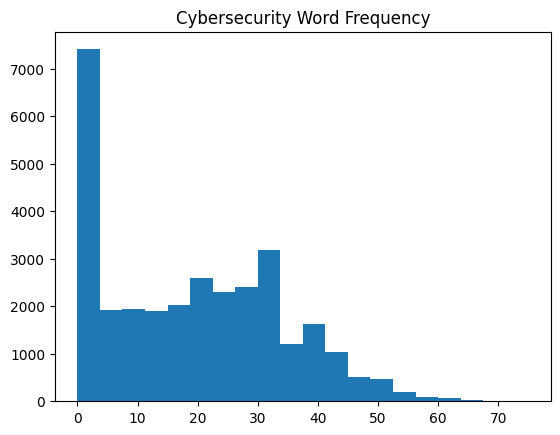

In [94]:
plot_histograms(data_freq, title_freq)

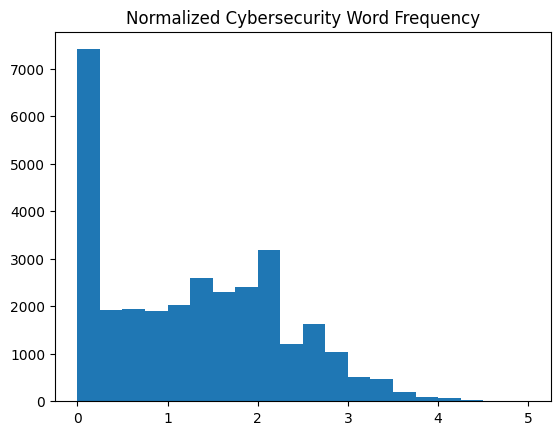

In [97]:
normalized_data_freq_reg = normalize_data(data_freq)
plot_histograms(normalized_data_freq_reg, "Normalized Cybersecurity Word Frequency")

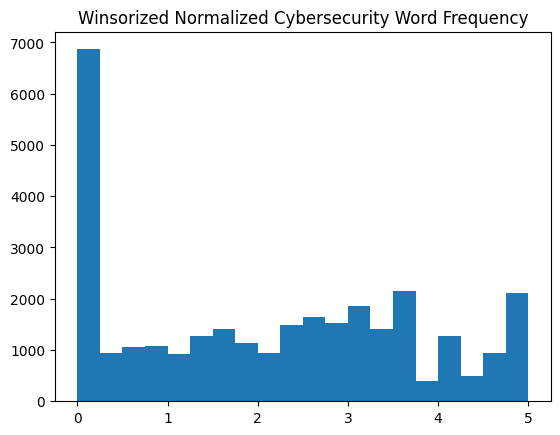

In [98]:
normalized_data_freq = winsorize_normalize(data_freq, lower_bound=None, upper_bound=0.05)
plot_histograms(normalized_data_freq, "Winsorized Normalized Cybersecurity Word Frequency")

In [54]:
data, title = ssl_metric("surprisal")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


5799


In [99]:
data

[20.02518231528146,
 20.58546769618988,
 16.269359970092772,
 28.381174087524414,
 23.371296882629395,
 35.4223575592041,
 21.62373685836792,
 22.676125253949845,
 20.655885696411133,
 23.817222690582277,
 23.693546930948894,
 21.1207932472229,
 20.68996508916219,
 17.048630578177317,
 19.946888065338136,
 15.917851448059082,
 21.302913665771484,
 15.269933700561523,
 0,
 21.062334696451824,
 19.129732813153947,
 14.045164108276367,
 20.36490331377302,
 21.421770572662354,
 20.958844820658367,
 14.07046127319336,
 24.685173988342285,
 19.705732107162476,
 22.411690831184387,
 0,
 18.625154427119664,
 21.40068416595459,
 23.92124814253587,
 16.369913864135743,
 22.444879722595214,
 18.219974199930828,
 17.682745695114136,
 18.510741580616344,
 22.20058431625366,
 21.052936962672643,
 21.447481354077656,
 25.7272793451945,
 22.625269571940105,
 15.31273078918457,
 20.15327113015311,
 21.04064416885376,
 20.89278621673584,
 25.260351701216265,
 15.193799018859863,
 26.795616149902344,
 23

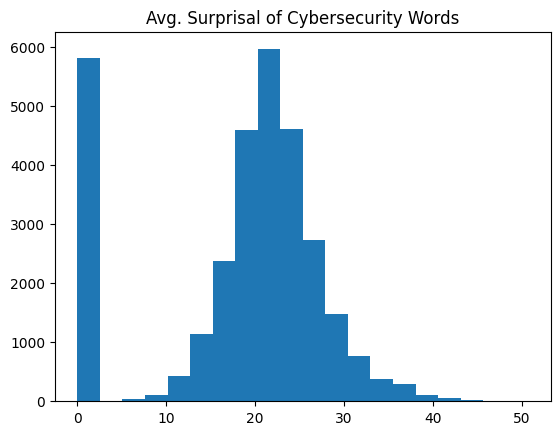

In [101]:
plot_histograms(data, "Avg. Surprisal of Cybersecurity Words")

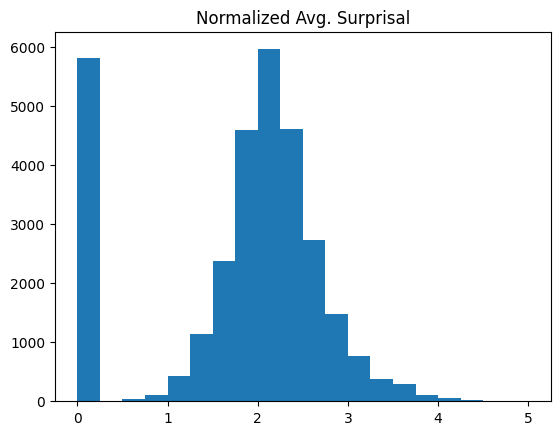

In [102]:
normalized_data_surp = normalize_data(data)
plot_histograms(normalized_data_surp, "Normalized Avg. Surprisal")

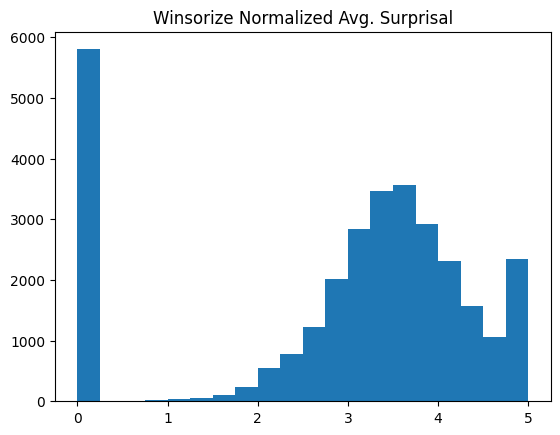

In [103]:
normalized_data = winsorize_normalize(data, lower_bound=None, upper_bound=0.05)
plot_histograms(normalized_data, "Winsorize Normalized Avg. Surprisal")

30903


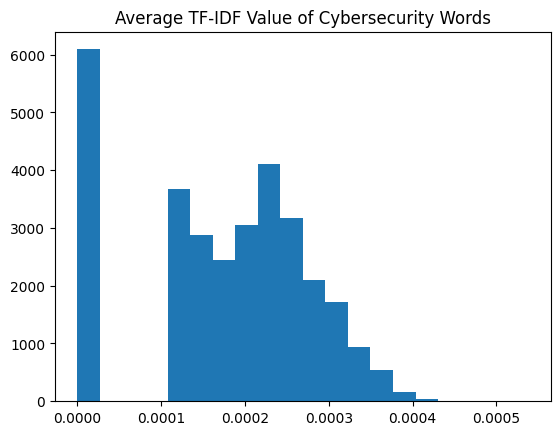

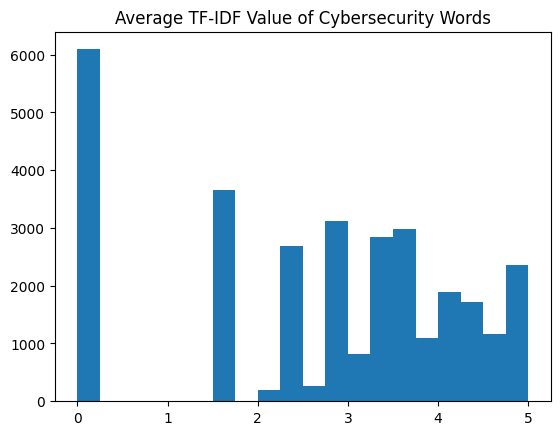

In [59]:
data_tf, title_tf = ssl_metric("tfidf")
print(len(data_tf))
plot_histograms(data_tf, title_tf)
normalized_data_tf = winsorize_normalize(data_tf, lower_bound=0.05, upper_bound=0.05)
plot_histograms(normalized_data_tf, title_tf)

33.33333333333333


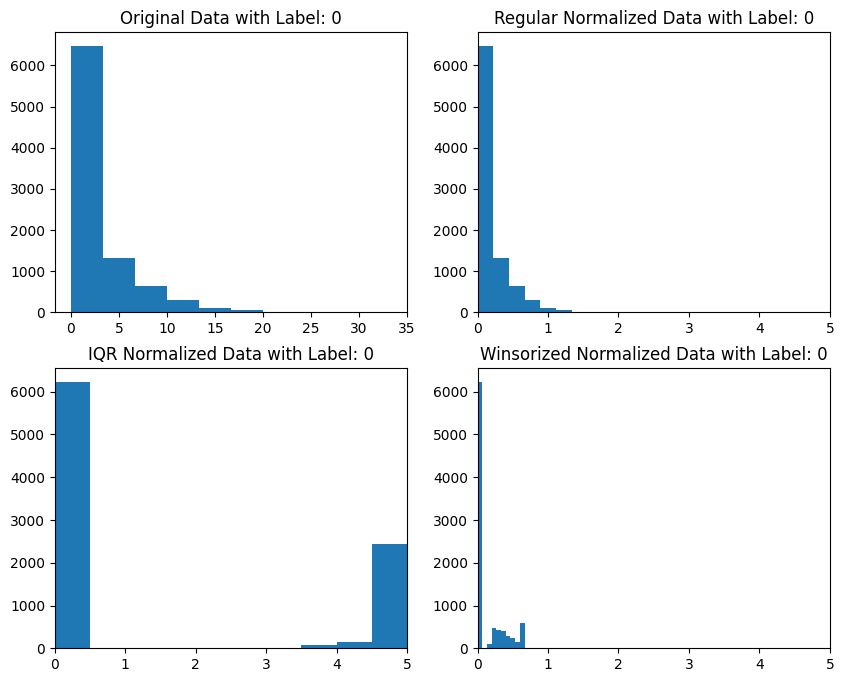

###########################################################################################################
66.66666666666666


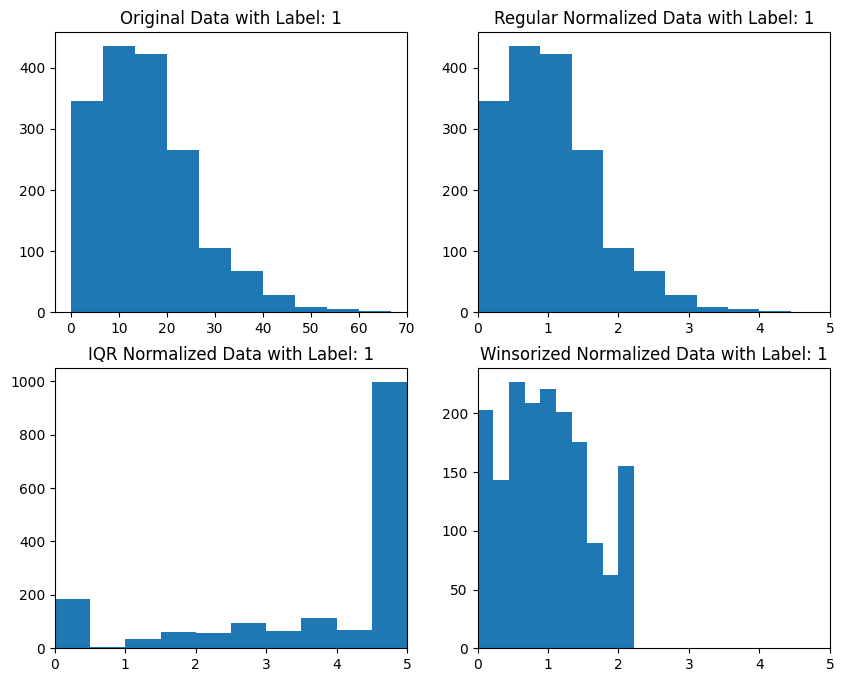

###########################################################################################################
60.0


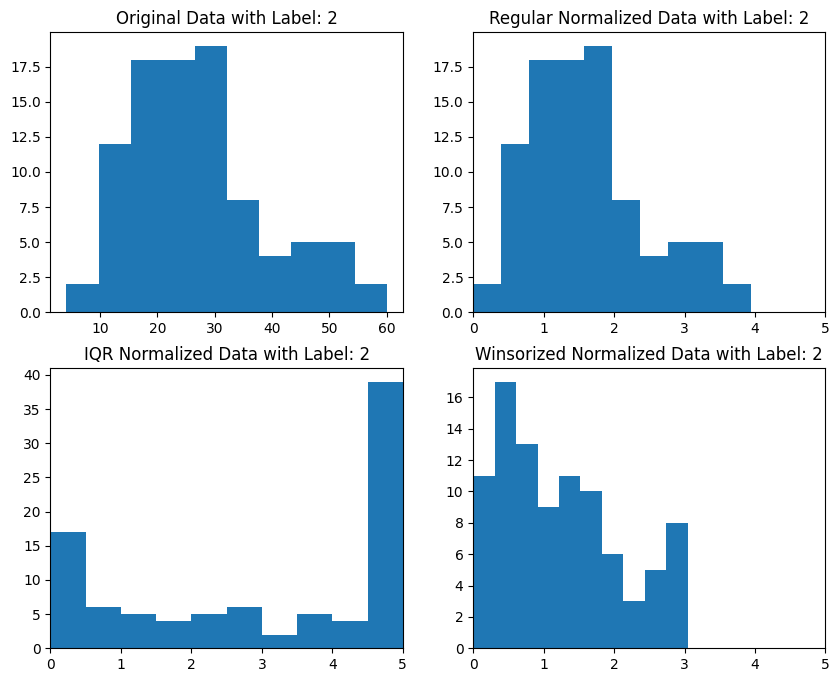

###########################################################################################################
71.42857142857143


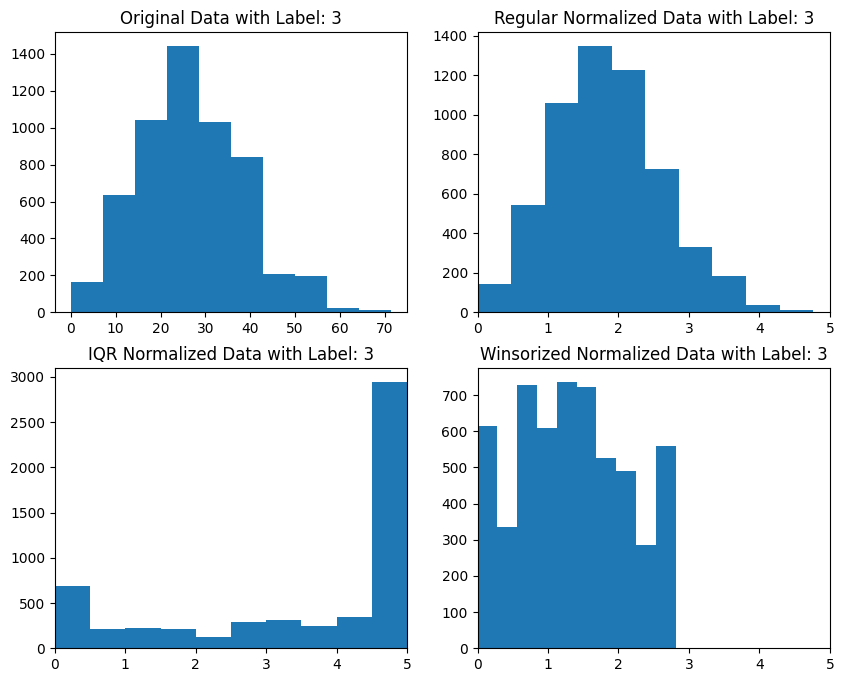

###########################################################################################################
71.42857142857143


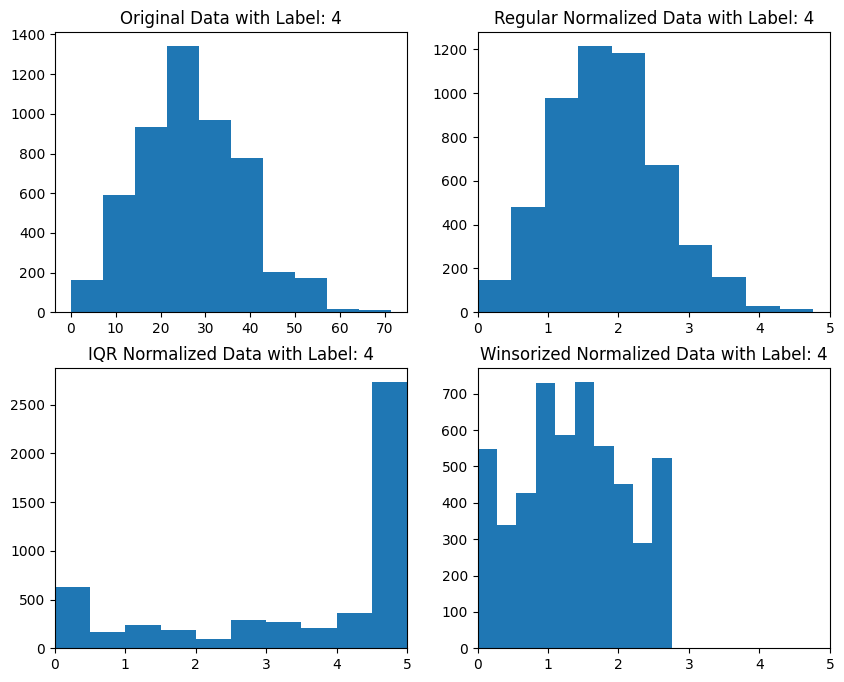

###########################################################################################################
75.0


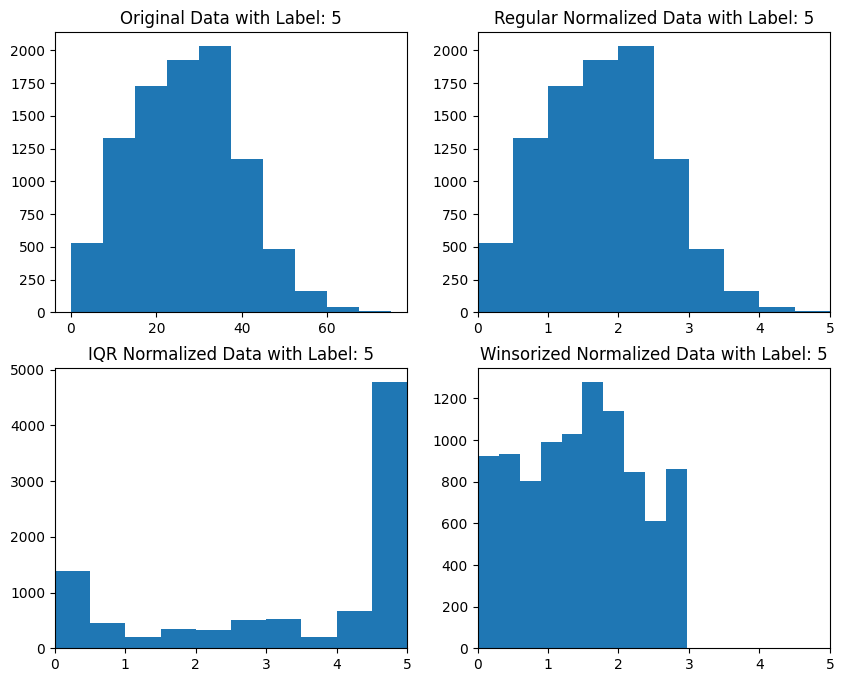

###########################################################################################################


In [13]:
max_value = 75
for i in range(6):
    categories = df[df['Label'] == i]
    categories_sentences = categories['Sentence'].dropna()
    categories_sentences = categories_sentences.astype(str).apply(lambda x: x.lower()).values
    num_words_per_sentence = calculate_frequency(categories_sentences,cybersecurity_words)
    print(max(num_words_per_sentence))
    iqr_normalized_data = iqr_normalize(num_words_per_sentence)
    winsorized_normalized_data = winsorize_normalize(num_words_per_sentence, max_value= 75)
    normalized_data = normalize_data(num_words_per_sentence, max_value= 75)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    ax[0, 0].hist(num_words_per_sentence, bins=10)
    ax[0, 0].set_title(f'Original Data with Label: {i}')
    ax[0, 1].hist(normalized_data, bins=10)
    ax[0, 1].set_xlim(0, 5)
    ax[0, 1].set_title(f'Regular Normalized Data with Label: {i}')
    ax[1, 0].hist(iqr_normalized_data, bins=10)
    ax[1, 0].set_xlim(0, 5)
    ax[1, 0].set_title(f'IQR Normalized Data with Label: {i}')
    ax[1, 1].hist(winsorized_normalized_data, bins=10)
    ax[1, 1].set_xlim(0, 5)
    ax[1, 1].set_title(f'Winsorized Normalized Data with Label: {i}')

    plt.show()
    print("###########################################################################################################")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


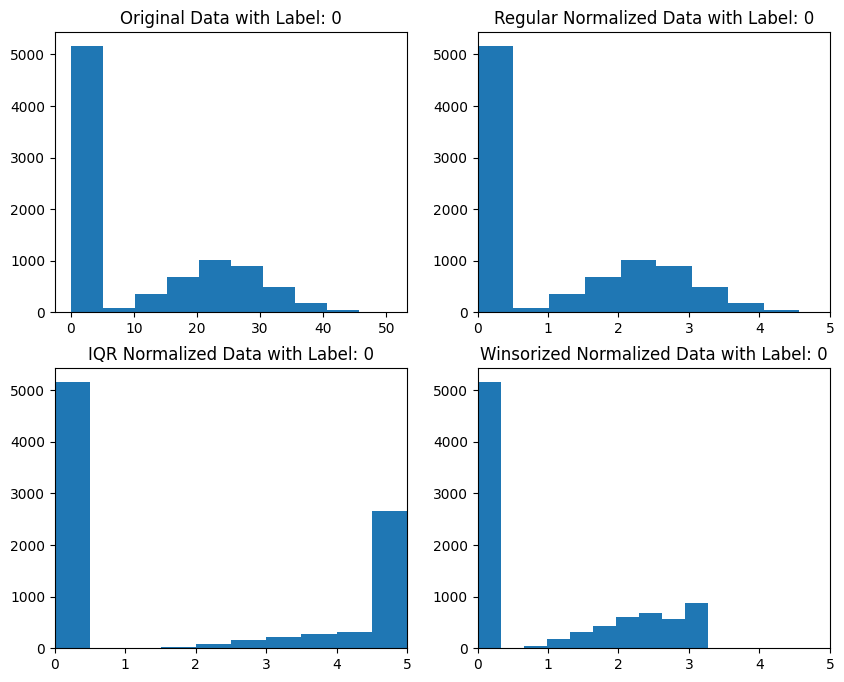

###########################################################################################################


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


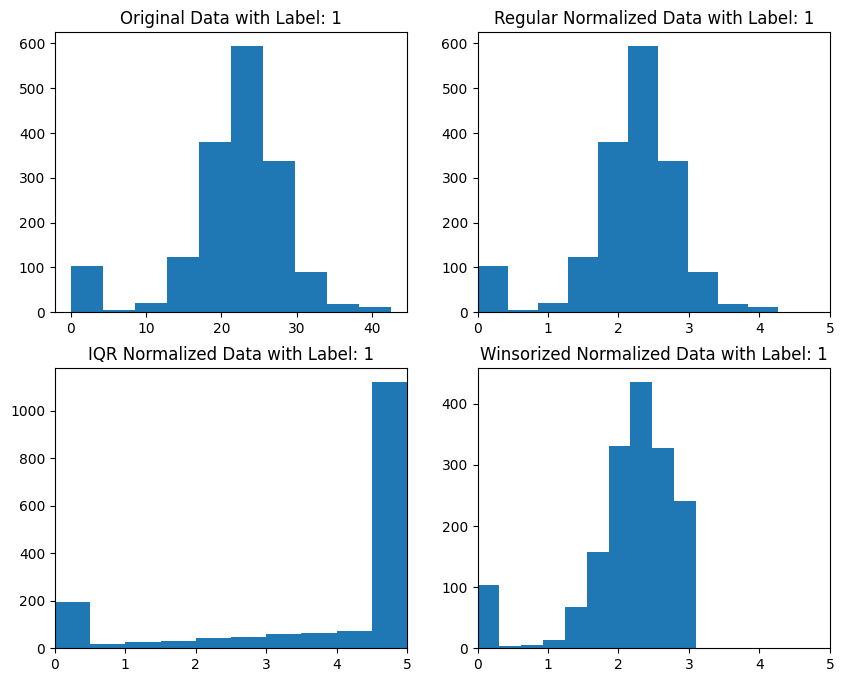

###########################################################################################################


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


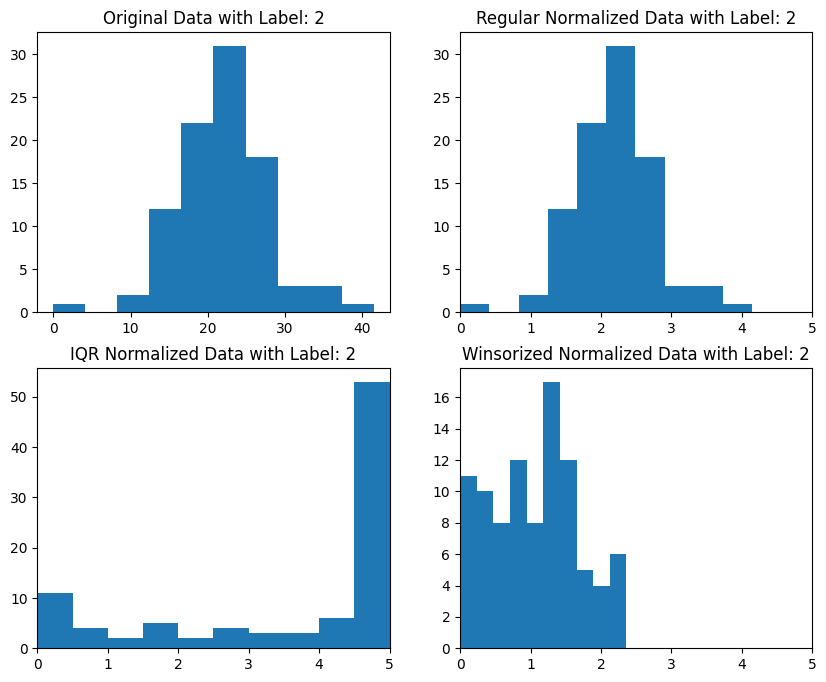

###########################################################################################################


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


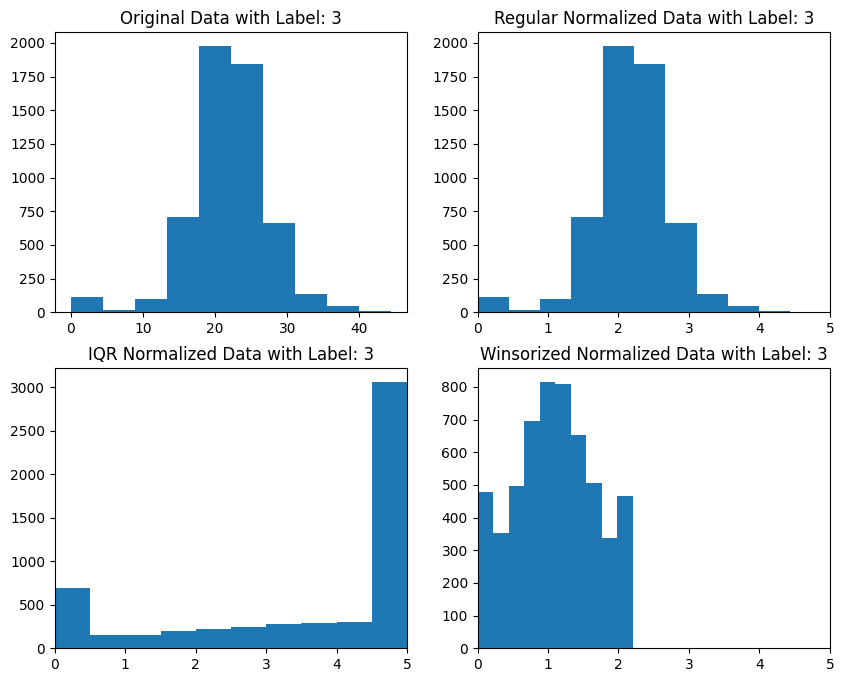

###########################################################################################################


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


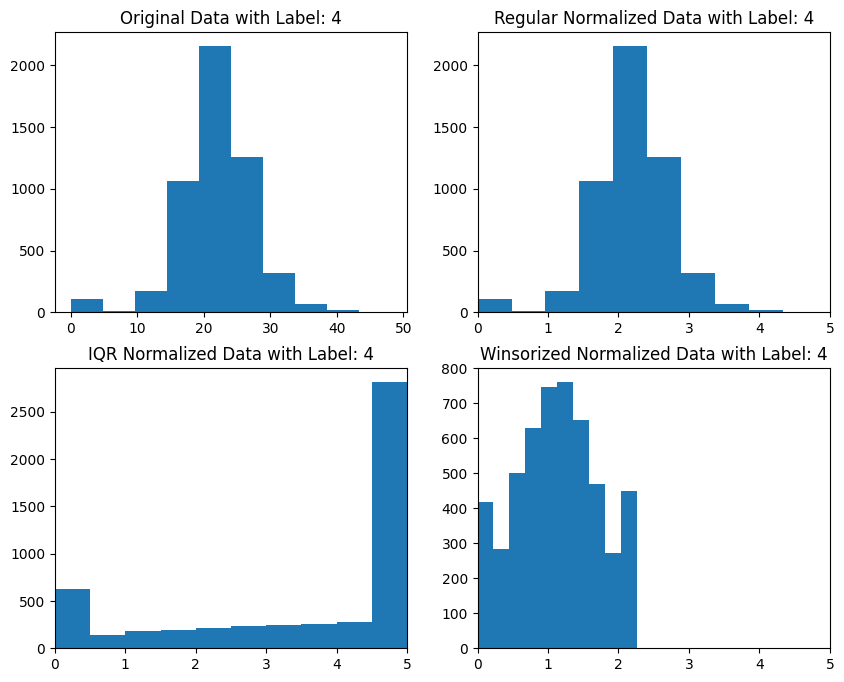

###########################################################################################################


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


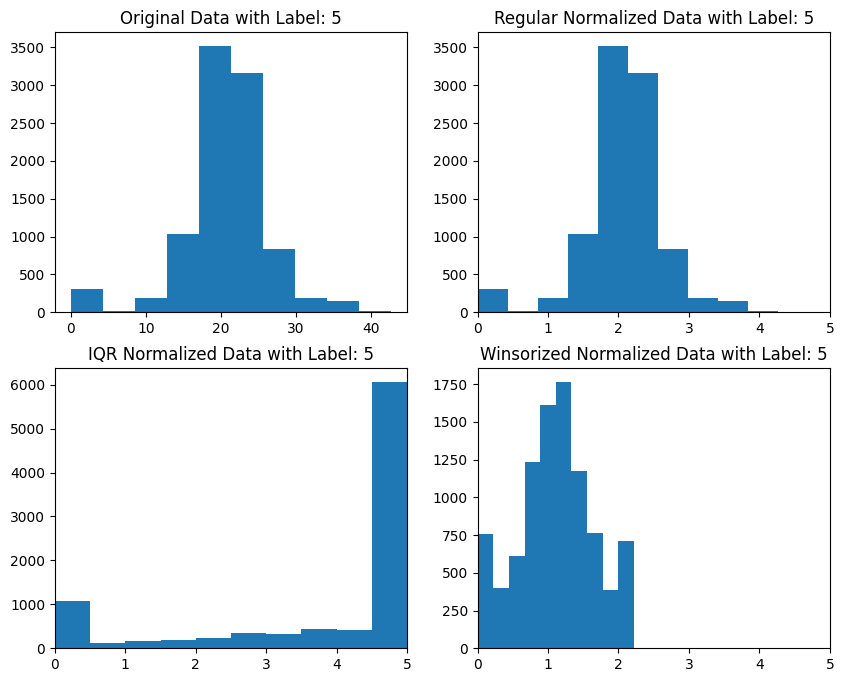

###########################################################################################################


In [62]:
for i in range(6):
    categories = df[df['Label'] == i]
    categories_sentences = categories['Sentence'].dropna()
    categories_sentences = categories_sentences.astype(str).apply(lambda x: x.lower()).values
    top_words_dict, avg_surprisal_sentences = surprisal_cybersecurity_words(categories_sentences,cybersecurity_words)
    iqr_normalized_data = iqr_normalize(avg_surprisal_sentences)
    winsorized_normalized_data = winsorize_normalize(avg_surprisal_sentences, max_value= 50)
    normalized_data = normalize_data(avg_surprisal_sentences, max_value= 50)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    ax[0, 0].hist(avg_surprisal_sentences, bins=10)
    ax[0, 0].set_title(f'Original Data with Label: {i}')
    ax[0, 1].hist(normalized_data, bins=10)
    ax[0, 1].set_xlim(0, 5)
    ax[0, 1].set_title(f'Regular Normalized Data with Label: {i}')
    ax[1, 0].hist(iqr_normalized_data, bins=10)
    ax[1, 0].set_xlim(0, 5)
    ax[1, 0].set_title(f'IQR Normalized Data with Label: {i}')
    ax[1, 1].hist(winsorized_normalized_data, bins=10)
    ax[1, 1].set_xlim(0, 5)
    ax[1, 1].set_title(f'Winsorized Normalized Data with Label: {i}')

    plt.show()
    print("###########################################################################################################")

C:\Users\rf1679\AppData\Local\Temp\ipykernel_16280\917181145.py:4: RuntimeWarning: divide by zero encountered in divide
  normalized_data = (data - q1) / iqr_val
C:\Users\rf1679\AppData\Local\Temp\ipykernel_16280\917181145.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - q1) / iqr_val


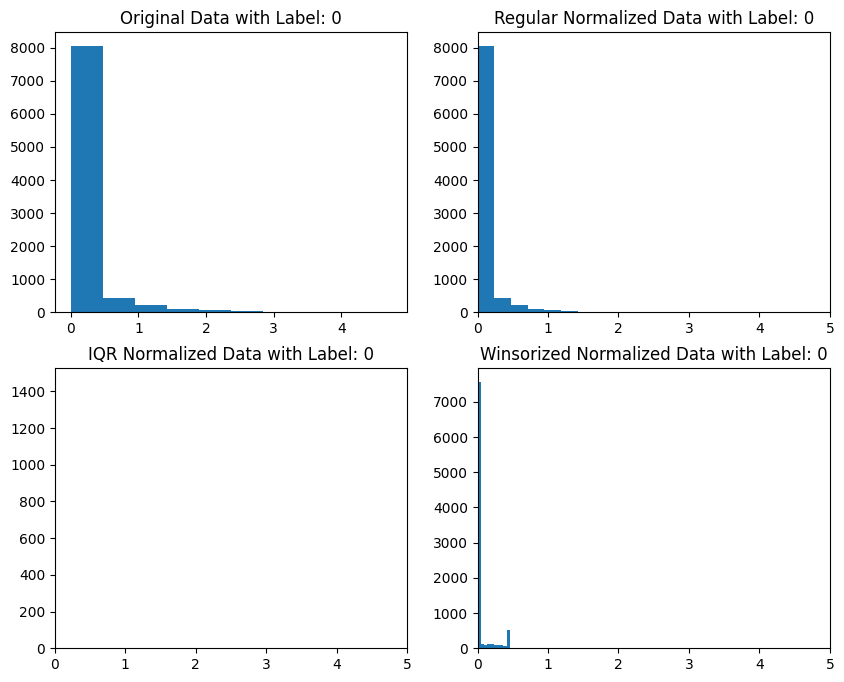

###########################################################################################################


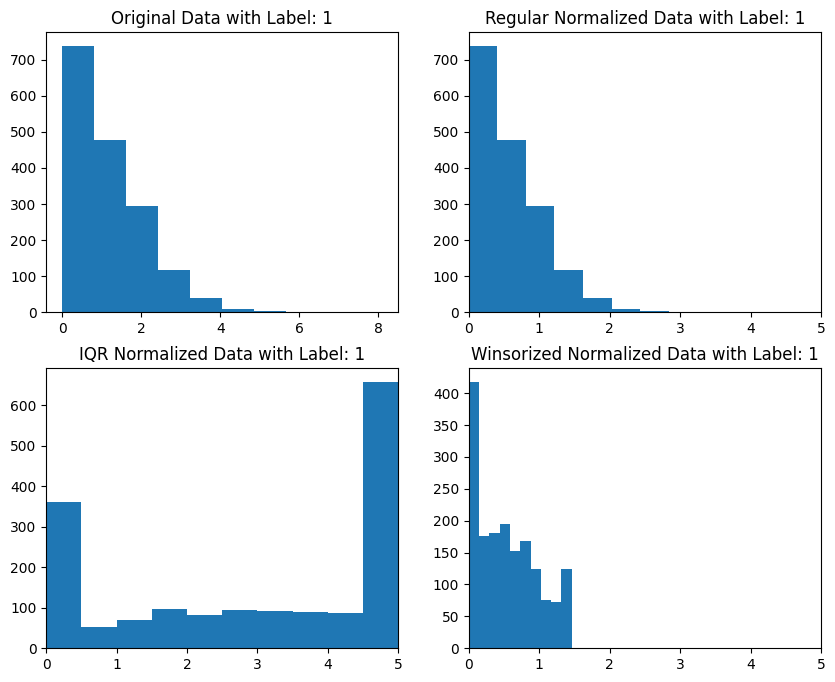

###########################################################################################################


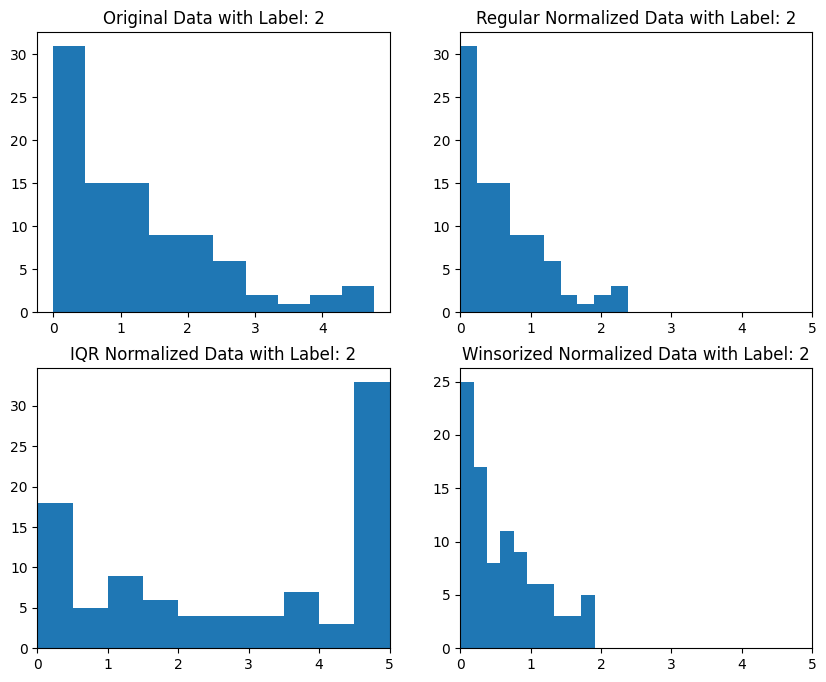

###########################################################################################################


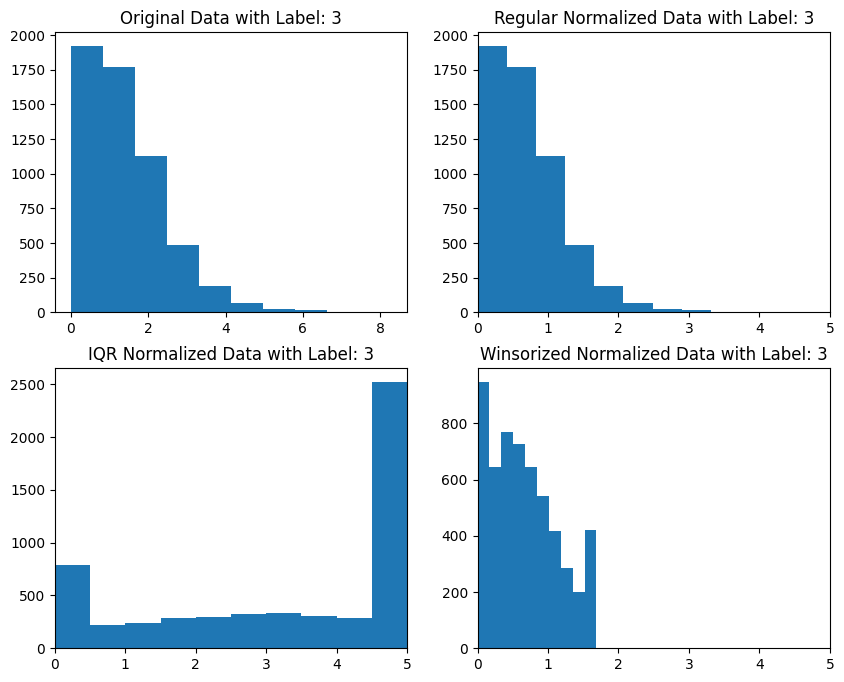

###########################################################################################################


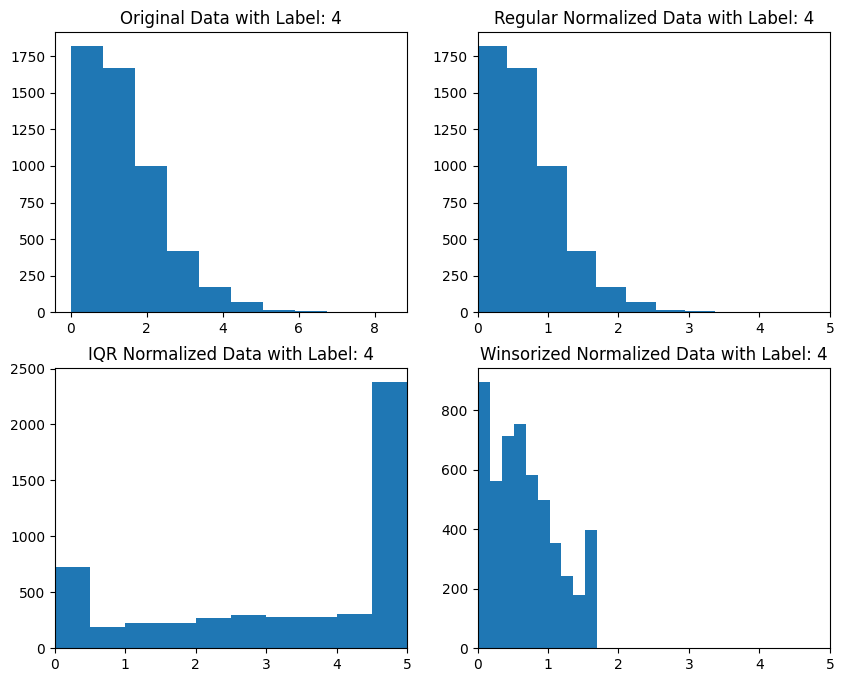

###########################################################################################################


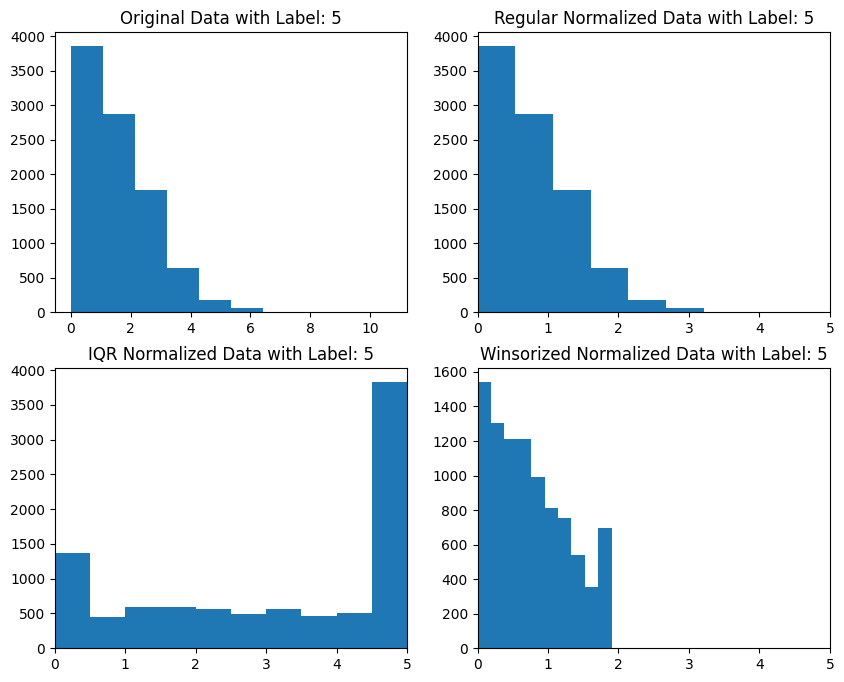

###########################################################################################################


In [92]:
for i in range(6):
    categories = df[df['Label'] == i]
    categories_sentences = categories['Sentence'].dropna()
    categories_sentences = categories_sentences.astype(str).apply(lambda x: x.lower()).values
    model_roberta = RobertaForMaskedLM.from_pretrained('roberta-base')
    model_securebert = RobertaForMaskedLM.from_pretrained('ehsanaghaei/SecureBERT')
    tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
    tokenizer_securebert = RobertaTokenizer.from_pretrained('ehsanaghaei/SecureBERT')
    distances = get_sentences_with_higher_rank(categories, cybersecurity_words, model_roberta, model_securebert, tokenizer_securebert, tokenizer_securebert)
    iqr_normalized_data = iqr_normalize(distances)
    winsorized_normalized_data = winsorize_normalize(distances,lower_bound= None, upper_bound= 0.05, max_value= 10)
    normalized_data = normalize_data(distances,max_value= 10)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    ax[0, 0].hist(distances, bins=10)
    ax[0, 0].set_title(f'Original Data with Label: {i}')
    ax[0, 1].hist(normalized_data, bins=10)
    ax[0, 1].set_xlim(0, 5)
    ax[0, 1].set_title(f'Regular Normalized Data with Label: {i}')
    ax[1, 0].hist(iqr_normalized_data, bins=10)
    ax[1, 0].set_xlim(0, 5)
    ax[1, 0].set_title(f'IQR Normalized Data with Label: {i}')
    ax[1, 1].hist(winsorized_normalized_data, bins=10)
    ax[1, 1].set_xlim(0, 5)
    ax[1, 1].set_title(f'Winsorized Normalized Data with Label: {i}')

    plt.show()
    print("###########################################################################################################")

In [64]:
data_rank, titl_rank = ssl_metric("rank")
print(len(data_rank))

A race condition was addressed with additional validation.
As a workaround, one may avoid using the "remember me" feature.
It has been rated as problematic.
The specific flaw exists within the WriteToFile method.
NOTE: some of these details are obtained from third party information.
The misbehavior occurs only with DTLS_VERIFY_PEERS_ON_RESUMPTION_THRESHOLD values larger than 0.
NOTE: some of these details are obtained from third party information.
AeroCMS v0.0.1 is vulnerable to ClickJacking.
This is related to snd_timer_open and snd_timer_close_locked.
In lockNow of PhoneWindowManager.java, there is a possible lock screen bypass due to a race condition.
android.intent.action.SIOP_LEVEL_CHANGED allows a serializable intent reboot.
The Samsung ID is SVE-2017-8363 (May 2017).
NOTE: this may be a CVE-2004-2265 regression.
NOTE: some of these details are obtained from third party information.
This problem has been patched in version 1.3.0.
If so, it should not be included in CVE.
NOTE: thi

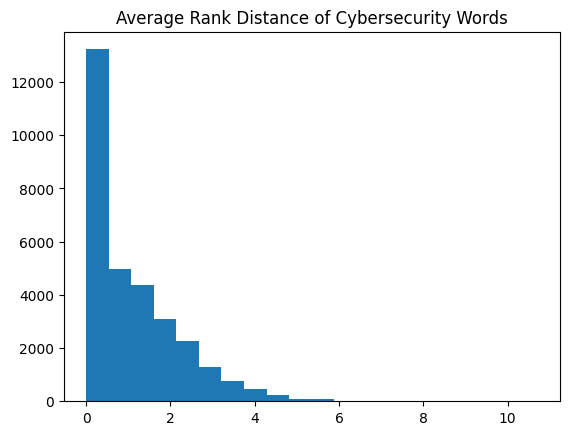

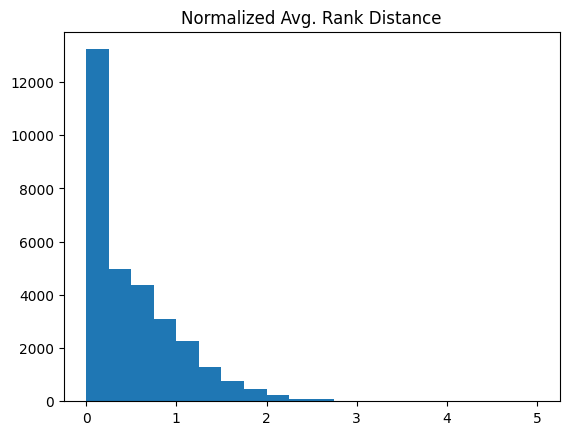

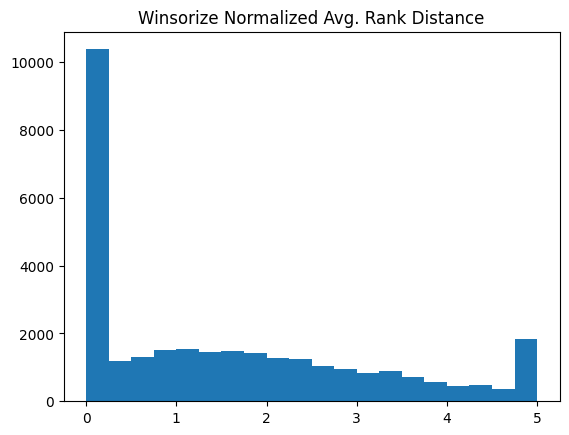

In [104]:
plot_histograms(data_rank, titl_rank)
normalized_data_rank_reg = normalize_data(data_rank)
plot_histograms(normalized_data_rank_reg, "Normalized Avg. Rank Distance")
normalized_data_rank = winsorize_normalize(data_rank, lower_bound=None, upper_bound=0.05)
plot_histograms(normalized_data_rank, "Winsorize Normalized Avg. Rank Distance")

In [69]:
len(data_rank)

30903

In [70]:
data_rank

[0.16361194523671507,
 0.6971165687792164,
 1.9677041295289364,
 1.2094314460431947,
 3.3994444887070765,
 0.5510330901274489,
 2.4373740290483465,
 1.5804836442282892,
 0.6990607785697055,
 2.7951358791300547,
 1.5037304881205127,
 2.108840767505288,
 0.969392789576801,
 0.5738043833316236,
 0.4754265217182452,
 2.860921002094988,
 1.6201271556373662,
 2.0209453349982276,
 1.267277482864424,
 2.846174072623632,
 0.5259152341198918,
 1.4465048004503238,
 3.532112751067507,
 0.21724068610348546,
 0.7798449645359495,
 0.44385411117388607,
 0.29224442491868824,
 2.6559120481568996,
 1.7615641238523227,
 3.210843653170936,
 1.6191132956190046,
 2.6995254658777257,
 0.7493524673623546,
 0.3885321353530206,
 2.3728555489907355,
 1.3596196172180286,
 0.9323768696257795,
 2.7094362967437515,
 0,
 1.9059666788811809,
 1.0073315262044407,
 0.762795574849787,
 0.5409971961248972,
 0.6020891375126212,
 3.000615754740839,
 1.2325091115908702,
 1.0031569661123667,
 2.01138321179092,
 1.2733588067484

In [71]:
non_zeros= []
for item in data_rank:
    if item != 0:
        non_zeros.append(item)
print(len(non_zeros))

21729


In [72]:
non_zeros

[0.16361194523671507,
 0.6971165687792164,
 1.9677041295289364,
 1.2094314460431947,
 3.3994444887070765,
 0.5510330901274489,
 2.4373740290483465,
 1.5804836442282892,
 0.6990607785697055,
 2.7951358791300547,
 1.5037304881205127,
 2.108840767505288,
 0.969392789576801,
 0.5738043833316236,
 0.4754265217182452,
 2.860921002094988,
 1.6201271556373662,
 2.0209453349982276,
 1.267277482864424,
 2.846174072623632,
 0.5259152341198918,
 1.4465048004503238,
 3.532112751067507,
 0.21724068610348546,
 0.7798449645359495,
 0.44385411117388607,
 0.29224442491868824,
 2.6559120481568996,
 1.7615641238523227,
 3.210843653170936,
 1.6191132956190046,
 2.6995254658777257,
 0.7493524673623546,
 0.3885321353530206,
 2.3728555489907355,
 1.3596196172180286,
 0.9323768696257795,
 2.7094362967437515,
 1.9059666788811809,
 1.0073315262044407,
 0.762795574849787,
 0.5409971961248972,
 0.6020891375126212,
 3.000615754740839,
 1.2325091115908702,
 1.0031569661123667,
 2.01138321179092,
 1.2733588067484192,

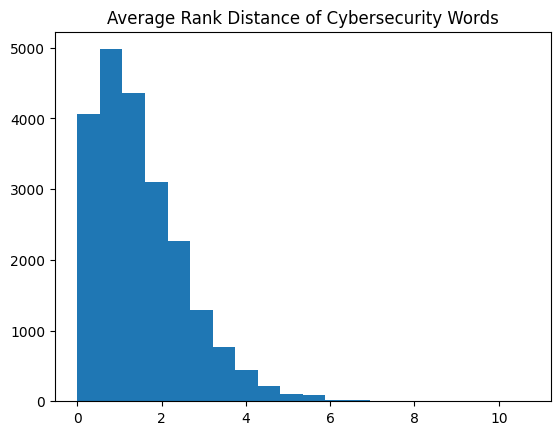

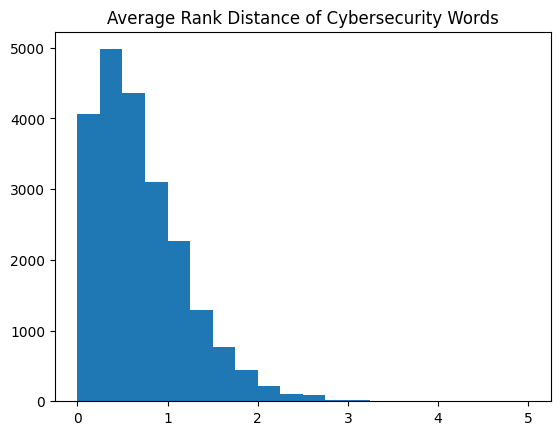

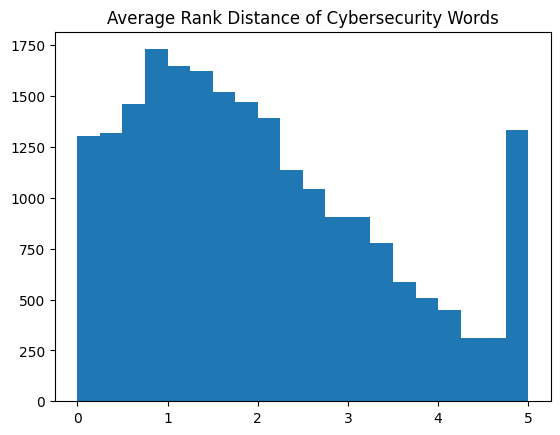

In [77]:
plot_histograms(non_zeros, titl_rank)
normalized_non_zeros_rank = normalize_data(non_zeros)
plot_histograms(normalized_non_zeros_rank, titl_rank)
normalized_non_zeros_rank_winsorize = winsorize_normalize(non_zeros, upper_bound=0.05, lower_bound=None)
plot_histograms(normalized_non_zeros_rank_winsorize, titl_rank)

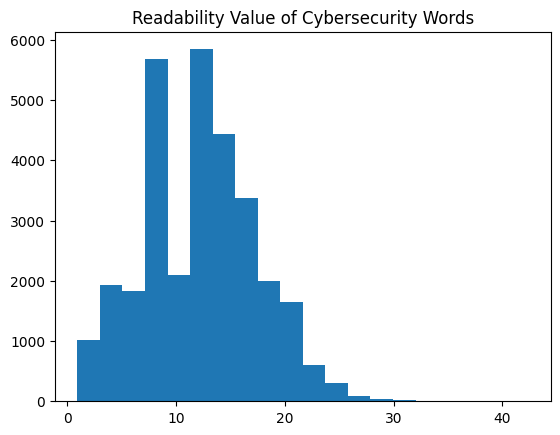

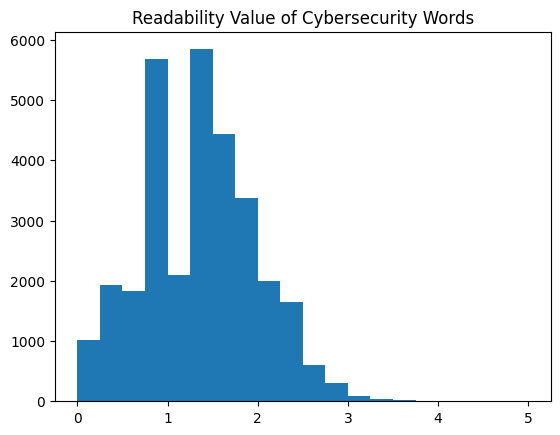

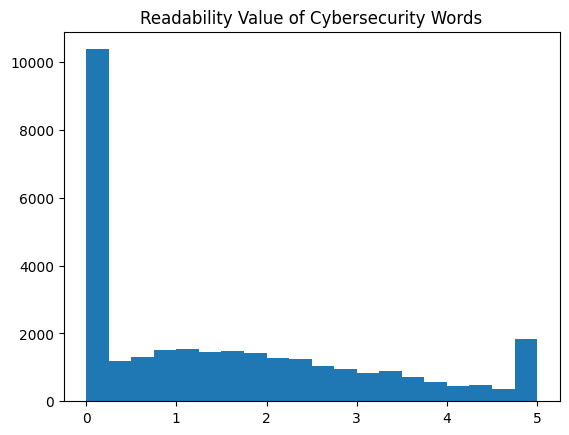

In [81]:
data_readability, title_readability = ssl_metric("readibility")
plot_histograms(data_readability, title_readability)
normalized_readability = normalize_data(data_readability)
plot_histograms(normalized_readability, title_readability)
normalized_data_readability = winsorize_normalize(data_readability, lower_bound=None, upper_bound=0.05)
plot_histograms(normalized_data_rank, title_readability)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rf1679\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


30903


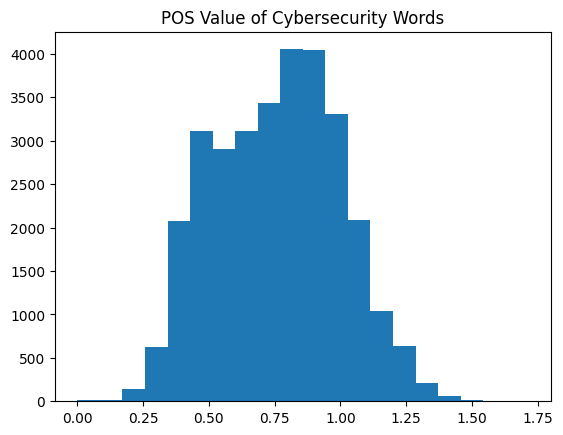

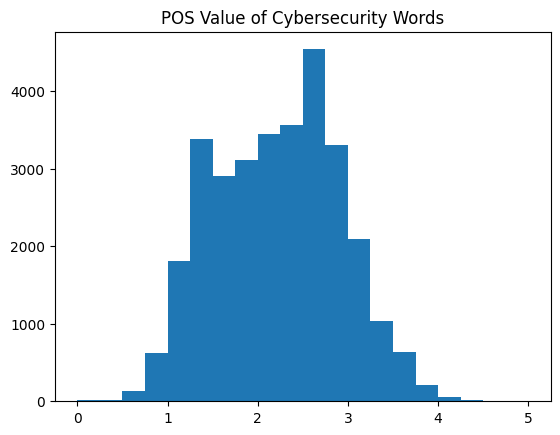

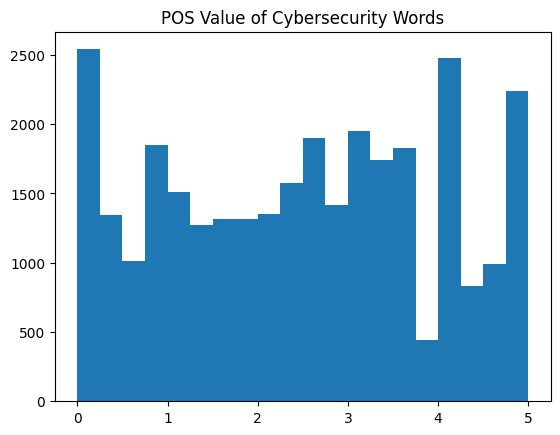

In [89]:
import nltk
nltk.download('averaged_perceptron_tagger')
data_entities, title_entities = ssl_metric("pos")
print(len(data_entities))
plot_histograms(data_entities, title_entities)
normalized_data_pos = normalize_data(data_entities)
plot_histograms(normalized_data_pos, title_entities)
normalized_data_entities = winsorize_normalize(data_entities, lower_bound=0.05, upper_bound=0.05)
plot_histograms(normalized_data_entities, title_entities)